# Empirical op scaling

A collection of visual checks for the scaling behaviour of `unit_scaling.functional` ops.

In [ ]:
%load_ext autoreload
%autoreload 2

from typing import *

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor

import unit_scaling.functional as U
from unit_scaling.core.functional import rms

def fmt_ratio(x: float) -> str:
    return f"1/{int(1/x)}" if x < 1 else f"{x:.0f}"

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rc("legend", frameon=False)

# `softmax`

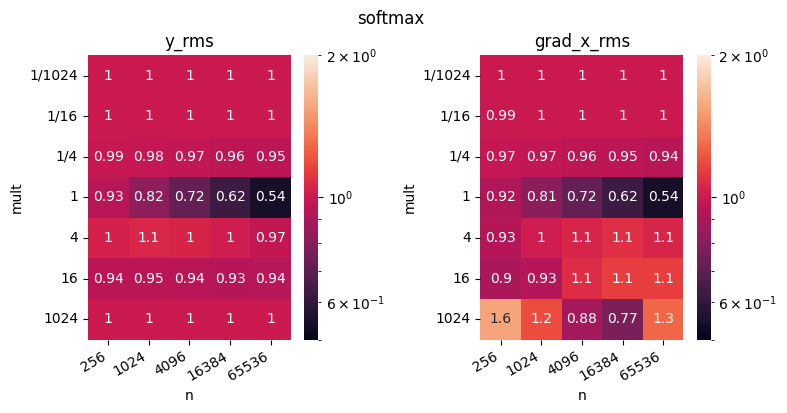

In [15]:
results = []
for mult in [2**-10, 1/16, 1/4, 1, 4, 16, 2**10]:
    for n in [256, 1024, 4096, 16384, 65536]:
        x = torch.randn(int(1e3), n).requires_grad_()
        y = U.softmax(x, dim=1, mult=mult, constraint=None)
        y.backward(torch.randn_like(y))
        results.append(dict(mult=mult, n=n, y_rms=float(rms(y)), grad_x_rms=float(rms(x.grad))))

df = pd.DataFrame.from_dict(results)
_, axs = plt.subplots(ncols=2, nrows=1, figsize=(2*4, 4))
for stat, ax in zip(["y_rms", "grad_x_rms"], axs):
    grid = df.pivot(index="mult", columns="n", values=stat)
    sns.heatmap(grid, ax=ax, square=True, vmin=1/2, vmax=2, norm=matplotlib.colors.LogNorm(vmin=1/2, vmax=2),
                annot=True)
    ax.set_yticklabels(list(map(fmt_ratio, grid.index)))
    ax.set_xticklabels(list(map(fmt_ratio, grid.columns)), rotation=30, ha="right")
    ax.set_title(stat)
plt.tight_layout()
plt.suptitle("softmax", y=1.02);

# `scaled_dot_product_attention`

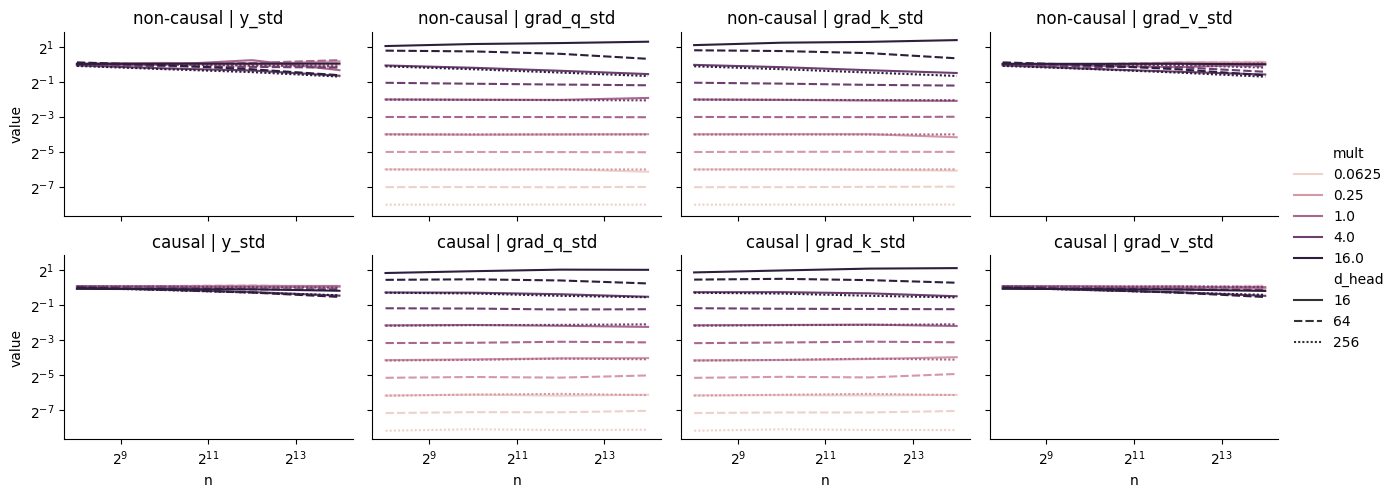

In [11]:
results = []
for is_causal in [False, True]:
    for mult in [1/16, 1/4, 1, 4, 16]:
        for n in [256, 1024, 4096, 16384]:
            for d_head in [16, 64, 256]:
                q, k, v = (x.requires_grad_() for x in torch.randn(3, 16384//n, n, d_head))
                out = U.scaled_dot_product_attention(q, k, v, is_causal=is_causal, mult=mult)
                out.backward(torch.randn_like(out))
                results.append(dict(is_causal=is_causal, mult=mult, n=n, d_head=d_head, y_std=float(out.std()),
                                    grad_q_std=float(q.grad.std()), grad_k_std=float(k.grad.std()), grad_v_std=float(v.grad.std())))

df = pd.DataFrame(results)
g = sns.relplot(data=df.melt(id_vars=["is_causal", "mult", "n", "d_head"], value_vars=["y_std", "grad_q_std", "grad_k_std", "grad_v_std"]),
                y="value", x="n", hue="mult", style="d_head", row="is_causal", col="variable",
                kind="line", hue_norm=matplotlib.colors.LogNorm(), aspect=1.3, height=2.5)
for (is_causal, variable), ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.set_title(("causal" if is_causal else "non-causal") + f" | {variable}")

# `gelu`, `silu`, `silu_glu`

<Axes: title={'center': 'silu_glu {}'}, xlabel='mult'>

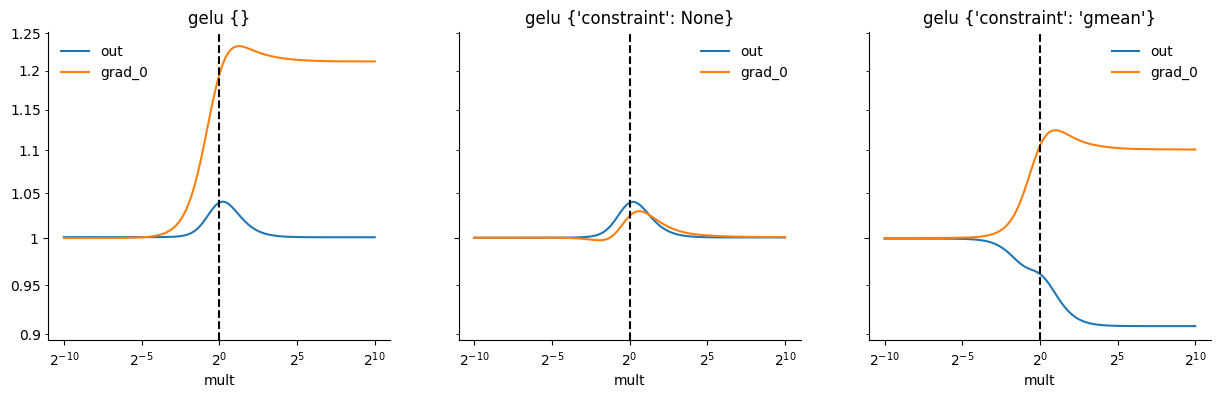

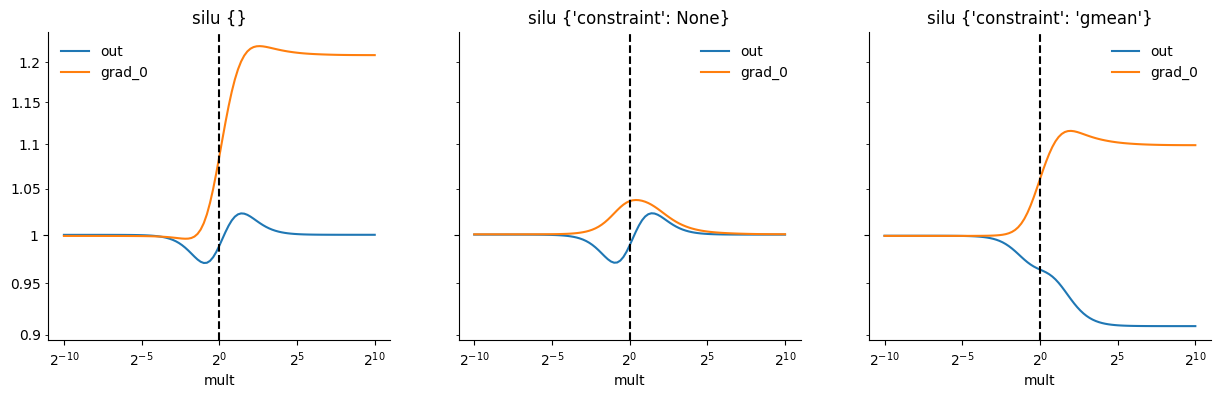

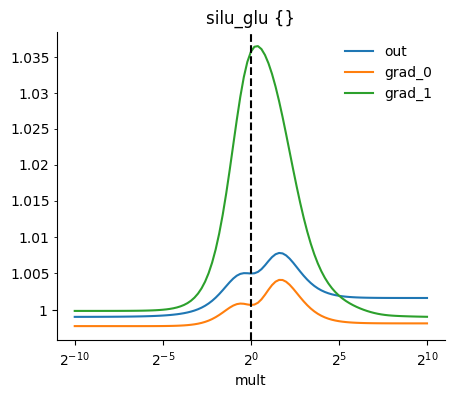

In [14]:
def show_elementwise_mult_sweep(fn: Callable[..., Tensor], narg: int, ax: Optional[matplotlib.axes.Axes] = None, **args: Any) -> matplotlib.axes.Axes:
    inputs = torch.randn(narg, int(1e6)).requires_grad_()
    grad = torch.randn(inputs.shape[1])
    mults = 2**torch.linspace(-10, 10, steps=101)
    stds = torch.zeros((len(mults), narg + 1))
    for mult, stdr in zip(mults, stds):
        inputs.grad = None
        y = fn(*inputs, mult=mult, **args)
        y.backward(grad)
        stdr[0] = y.std().detach()
        stdr[1:] = inputs.grad.std(1)
    if ax is None:
        plt.figure(figsize=(5, 4))
        ax = plt.gca()
    ax.plot(mults, stds)
    ax.axvline(1, color="k", ls="--")
    ax.legend(["out"] + [f"grad_{i}" for i in range(narg)])
    ax.set_xscale("log", base=2)
    ax.set_xticks(2**torch.linspace(-10, 10, steps=5))
    ax.set_xlabel("mult")
    ax.set_title(f"{fn.__name__} {args}")
    ax.set_yscale("log", base=10)
    ax.yaxis.set_major_formatter(lambda x, _: f"{float(x):.4g}")
    ax.yaxis.set_minor_formatter(lambda x, _: f"{float(x):.4g}")
    return ax

def show_elementwise_series(fn: Callable[..., Tensor], narg: int, settings: List[Dict[str, Any]]) -> None:
    _, axs = plt.subplots(ncols=len(settings), nrows=1, figsize=(len(settings)*5, 4), sharey="row")
    for ax, args in zip(axs, settings):
        show_elementwise_mult_sweep(fn, narg=narg, ax=ax, **args)

show_elementwise_series(U.gelu, 1, [{}, dict(constraint=None), dict(constraint="gmean")])
show_elementwise_series(U.silu, 1, [{}, dict(constraint=None), dict(constraint="gmean")])
show_elementwise_mult_sweep(U.silu_glu, 2)